In [283]:
import os
import cv2
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False
from func import *
import json
import ast

In [284]:
df = pd.read_csv("refine_merged_df.csv")
print(df.shape)
print(df.columns)
df.head()

(6334, 25)
Index(['image_file', 'center', 'scale', 'score', 'bbox', 'width', 'height',
       'bbox_size', 'x', 'y', 'entropy', 'laplacian', 'brightness', 'B_sd',
       'red', 'blue', 'green', 'color_var', 'c_moment', 'contrast', 'img_size',
       'edge_intensity', 'c_moment_x', 'c_moment_y', 'bbox_prop'],
      dtype='object')


,image_file,center,scale,score,bbox,width,height,bbox_size,x,y,...,blue,green,color_var,c_moment,contrast,img_size,edge_intensity,c_moment_x,c_moment_y,bbox_prop
0,val2017/000000152686.jpg,"[318.7799987792969, 205.77999877929688]","[1.7105625867843628, 2.280750036239624]",0.960156,"[231.39, 23.32, 175.78, 365.92]",175.78,365.92,64321.4176,231.39,23.32,...,116.950716,117.504579,5611.808144,"(84, 166)",1.0,256000,37.997495,84,166,0.251256
1,val2017/000000356505.jpg,"[310.1300048828125, 220.11500549316406]","[1.2599530220031738, 1.6799376010894775]",0.946107,"[222.64, 85.72, 175.98, 269.79]",175.98,269.79,47477.6442,222.64,85.72,...,132.133001,133.655104,3492.515846,"(86, 141)",1.0,272000,78.604461,86,141,0.174550
2,val2017/000000127270.jpg,"[162.24000549316406, 270.19000244140625]","[2.075343608856201, 2.767125129699707]",0.945302,"[39.11, 48.82, 247.26, 443.74]",247.26,443.74,109719.1524,39.11,48.82,...,145.894198,142.042158,3423.989375,"(123, 225)",1.0,164000,27.886146,123,225,0.669019
3,val2017/000000097988.jpg,"[257.364990234375, 404.5199890136719]","[1.8068437576293945, 2.4091248512268066]",0.942805,"[195.29, 211.79, 125.15, 386.46]",125.15,386.46,48365.4690,195.29,211.79,...,78.445679,105.133637,3633.292748,"(62, 168)",1.0,374544,70.274301,62,168,0.129132
4,val2017/000000021879.jpg,"[339.6600036621094, 192.43499755859375]","[1.0657968521118164, 1.4210624694824219]",0.941582,"[274.43, 78.75, 131.46, 228.37]",131.46,228.37,30021.5202,274.43,78.75,...,157.968963,152.236608,1901.065476,"(65, 116)",1.0,273280,78.861491,65,116,0.109856


In [285]:
# 정렬 확인
df.score.head(20)

0     0.960156
1     0.946107
2     0.945302
3     0.942805
4     0.941582
5     0.941547
6     0.940140
7     0.938948
8     0.938645
9     0.937699
10    0.935784
11    0.935221
12    0.934887
13    0.934448
14    0.934214
15    0.933999
16    0.933420
17    0.933344
18    0.933064
19    0.932366
Name: score, dtype: float64

<Axes: title={'center': '전체 score 분포'}>

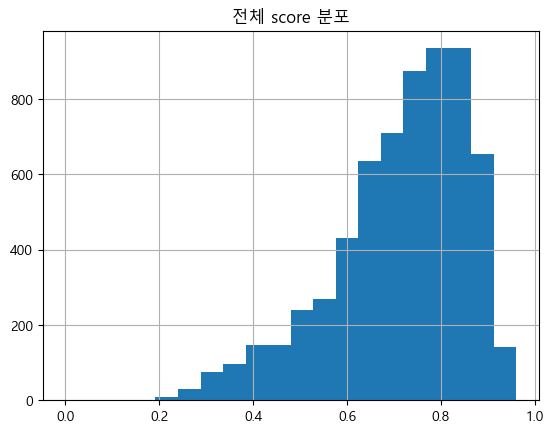

In [286]:
# score 분포
plt.title("전체 score 분포")
df['score'].hist(bins=20)

낮은 score 임의의 thr = 0.6으로 해보자

In [287]:
high_score = df[df['score']>0.85]
low_score = df[df['score']<0.6]

In [288]:
print("low score", len(low_score))
print("high_score", len(high_score))
print("전체", len(df))

low score 1204
high_score 1030
전체 6334


In [289]:
1030/6334

0.1626144616356173

## 1. Entropy

<Axes: title={'center': '전체 score 정렬 bbox'}>

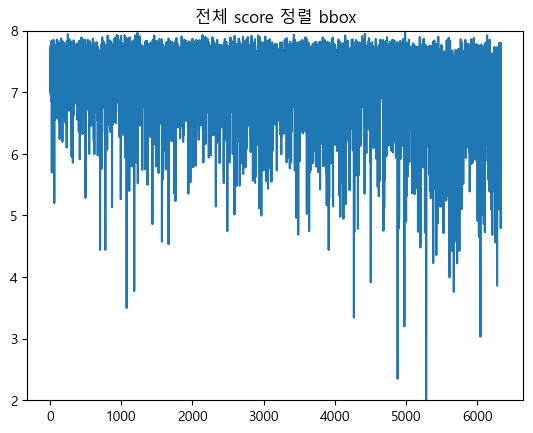

In [290]:
plt.title("전체 score 정렬 bbox")
plt.ylim(2,8)
df['entropy'].plot()

<Axes: title={'center': 'high_score'}, xlabel='score 정렬 bbox', ylabel='entropy'>

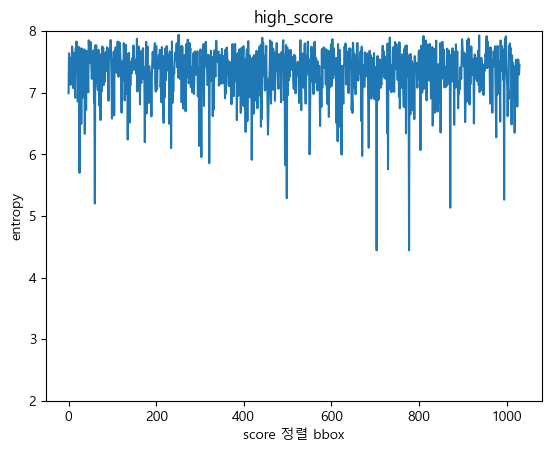

In [291]:
plt.title("high_score")
plt.xlabel("score 정렬 bbox")
plt.ylabel("entropy")
plt.ylim(2,8)
high_score['entropy'].plot()

<Axes: title={'center': 'low_score'}, xlabel='score 정렬 bbox', ylabel='entropy'>

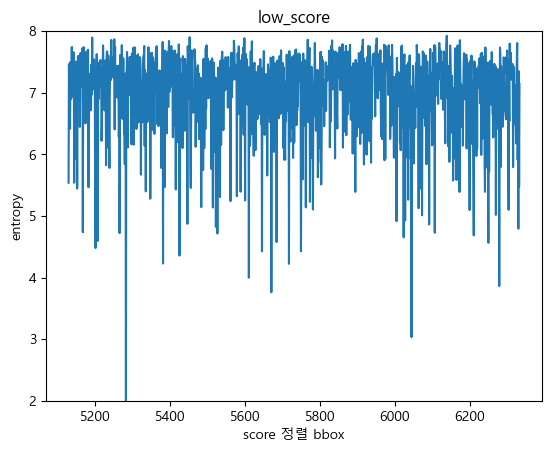

In [292]:
plt.title("low_score")
plt.xlabel("score 정렬 bbox")
plt.ylabel("entropy")
plt.ylim(2,8)
low_score['entropy'].plot()

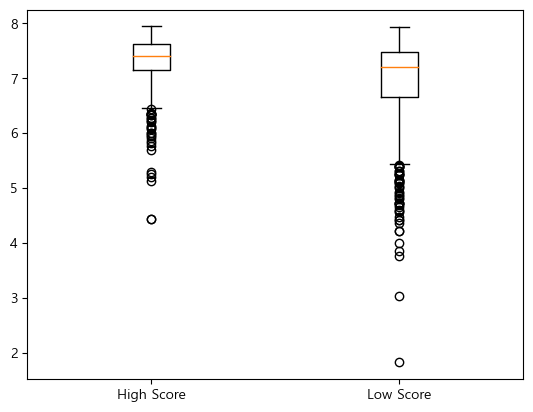

In [293]:
plt.boxplot([high_score['entropy'], low_score['entropy']], labels=['High Score', 'Low Score'])
plt.show()

In [294]:
df['entropy'].describe()

count    6334.000000
mean        7.190330
std         0.564483
min         1.826074
25%         6.979304
50%         7.334182
75%         7.573434
max         7.970288
Name: entropy, dtype: float64

In [295]:
high_score['entropy'].describe()

count    1030.000000
mean        7.325675
std         0.412962
min         4.441361
25%         7.146713
50%         7.407518
75%         7.614841
max         7.941068
Name: entropy, dtype: float64

In [296]:
low_score['entropy'].describe()

count    1204.000000
mean        6.982848
std         0.704352
min         1.826074
25%         6.656750
50%         7.201698
75%         7.472511
max         7.924931
Name: entropy, dtype: float64

## 2. sharpness - Laplacian

<Axes: title={'center': '(score 정렬) 전체 bbox laplacian'}>

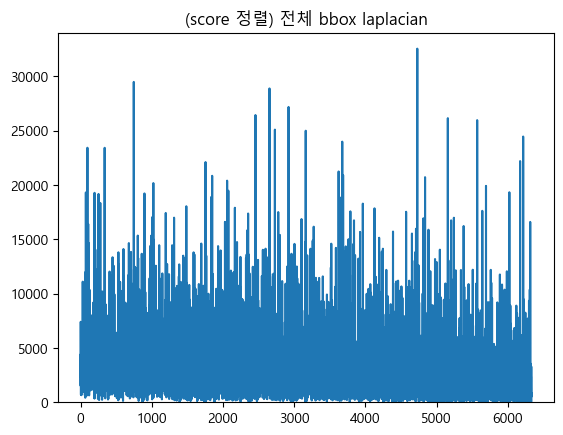

In [297]:
plt.title("(score 정렬) 전체 bbox laplacian")
plt.ylim(0,34000)
df['laplacian'].plot()

<Axes: title={'center': 'high_score의 laplacian'}, xlabel='score 정렬 bbox', ylabel='laplacian'>

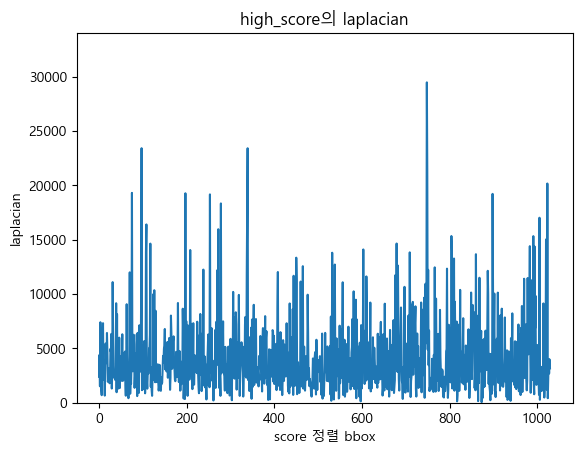

In [298]:
plt.title("high_score의 laplacian")
plt.xlabel("score 정렬 bbox")
plt.ylabel("laplacian")
plt.ylim(0,34000)
high_score['laplacian'].plot()

<Axes: title={'center': 'low_score의 laplacian'}, xlabel='score 정렬 bbox', ylabel='laplacian'>

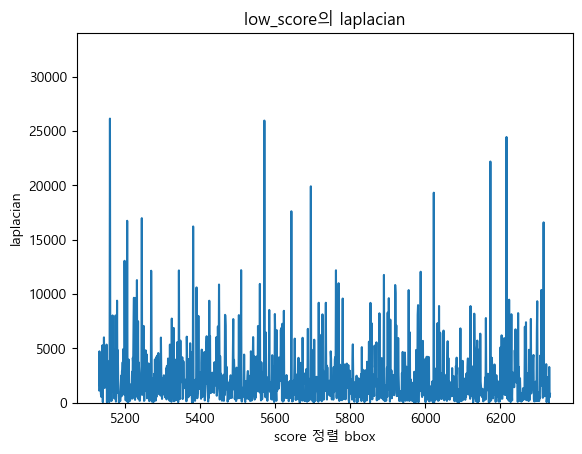

In [299]:
plt.title("low_score의 laplacian")
plt.xlabel("score 정렬 bbox")
plt.ylabel("laplacian")
plt.ylim(0,34000)
low_score['laplacian'].plot()

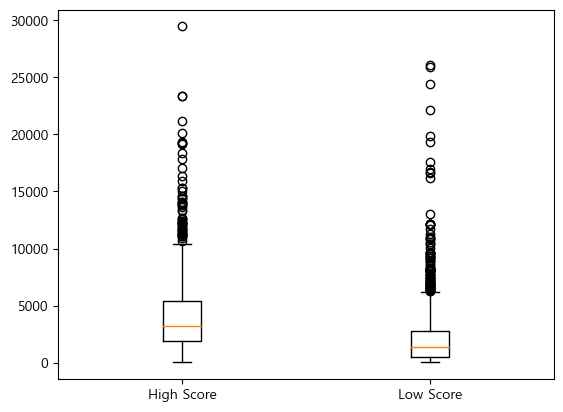

In [300]:
plt.boxplot([high_score['laplacian'], low_score['laplacian']], labels=['High Score', 'Low Score'])
plt.show()

In [301]:
print(np.mean(high_score['laplacian']))
print(np.mean(low_score['laplacian']))
print(np.mean(df['laplacian']))

4151.878904537419
2267.8558467765215
3399.9682106628525


## 3. brightness

<Axes: title={'center': 'low score brightness'}>

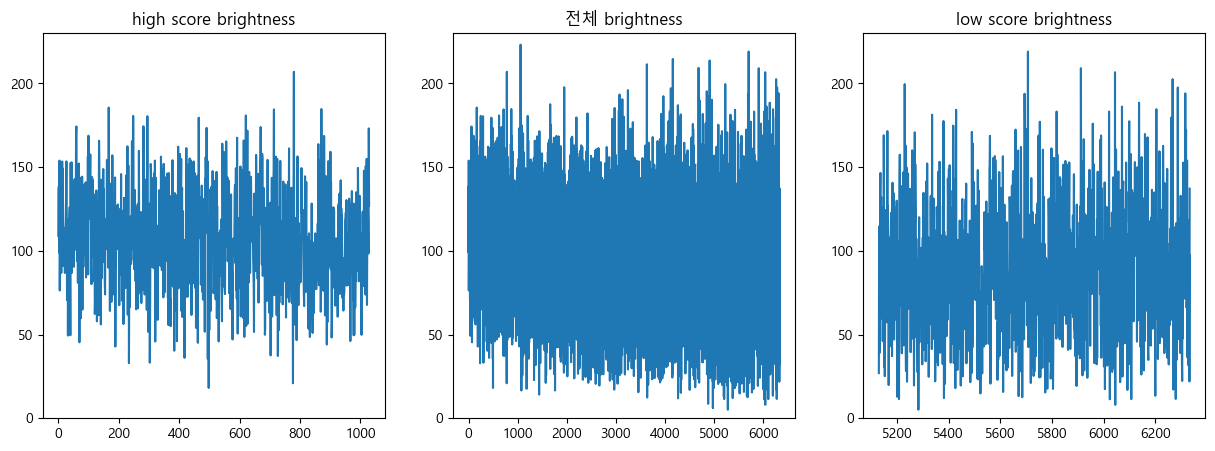

In [302]:
fig = plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.title("high score brightness")
plt.ylim(0,230)
high_score['brightness'].plot()

plt.subplot(1,3,2)
plt.title("전체 brightness")
plt.ylim(0,230)
df['brightness'].plot()

plt.subplot(1,3,3)
plt.title("low score brightness")
plt.ylim(0,230)
low_score['brightness'].plot()

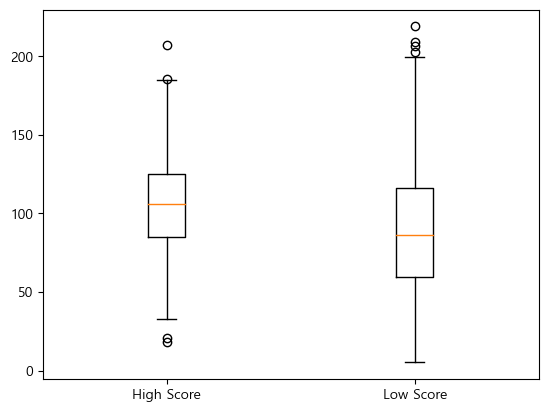

In [303]:
plt.boxplot([high_score['brightness'], low_score['brightness']], labels=['High Score', 'Low Score'])
plt.show()

In [304]:
print(np.mean(high_score['brightness']))
print(np.mean(low_score['brightness']))
print(np.mean(df['brightness']))

106.08909302978938
88.35483172820635
94.64175817053015


## 4. Color_var

<Axes: title={'center': 'low score color_var'}>

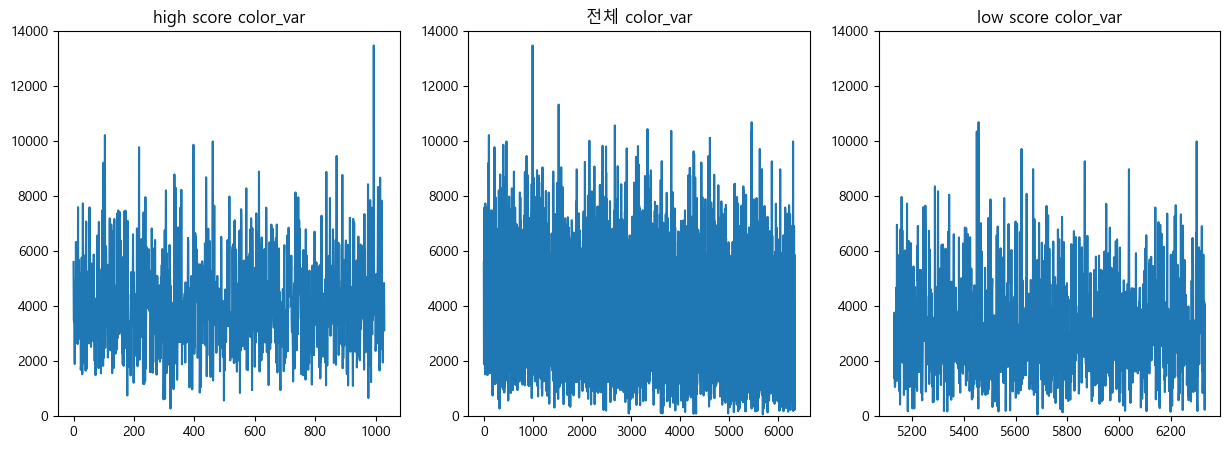

In [305]:
fig = plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.title("high score color_var")
plt.ylim(0,14000)
high_score['color_var'].plot()

plt.subplot(1,3,2)
plt.title("전체 color_var")
plt.ylim(0,14000)
df['color_var'].plot()

plt.subplot(1,3,3)
plt.title("low score color_var")
plt.ylim(0,14000)
low_score['color_var'].plot()

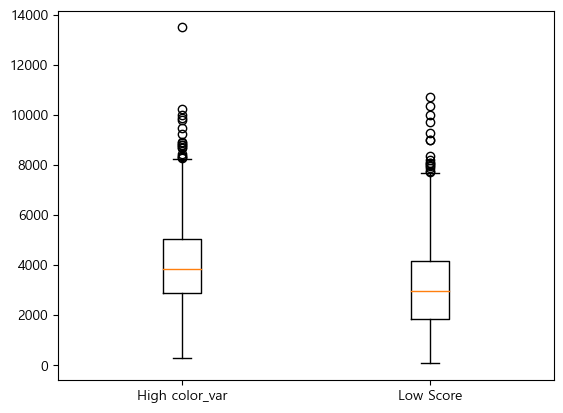

In [306]:
plt.boxplot([high_score['color_var'], low_score['color_var']], labels=['High color_var', 'Low Score'])
plt.show()

In [307]:
print(np.mean(high_score['color_var']))
print(np.mean(low_score['color_var']))
print(np.mean(df['color_var']))

4034.7570381332885
3159.3776392915343
3610.240743965359


In [308]:
numeric_df = df.select_dtypes(include='number')
correlations = numeric_df.corr()['score'].sort_values(ascending=False)

# 결과 출력
print(correlations)

score             1.000000
c_moment_y        0.229052
height            0.222186
entropy           0.204105
laplacian         0.190469
edge_intensity    0.176173
B_sd              0.153803
green             0.152622
color_var         0.149576
contrast          0.140210
brightness        0.139761
blue              0.131031
bbox_size         0.106493
bbox_prop         0.104145
red               0.103566
c_moment_x        0.044288
width             0.040816
y                 0.018073
img_size         -0.007977
x                -0.022917
Name: score, dtype: float64


## 5. RGB

<Axes: title={'center': 'low score red'}>

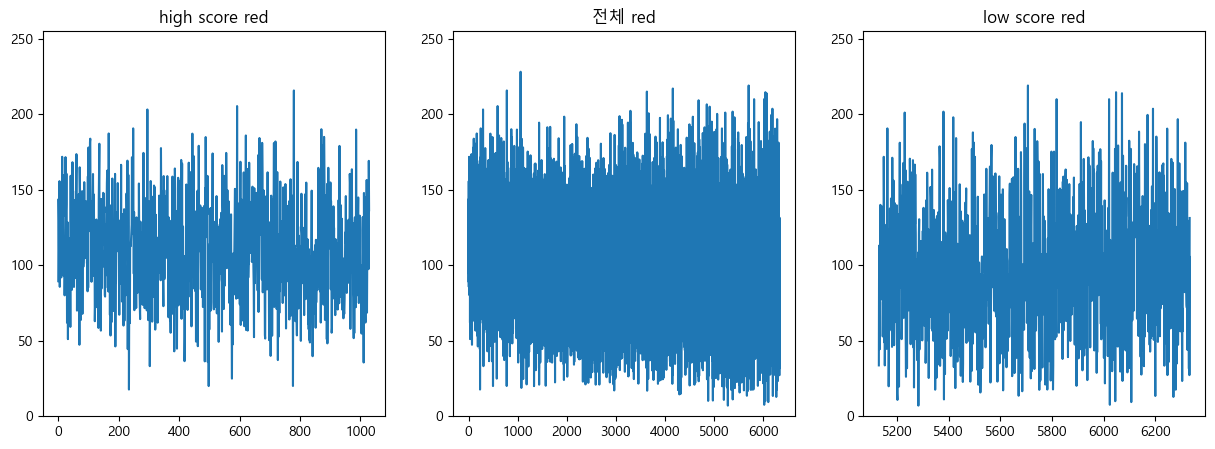

In [309]:
fig = plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.title("high score red")
plt.ylim(0,255)
high_score['red'].plot()

plt.subplot(1,3,2)
plt.title("전체 red")
plt.ylim(0,255)
df['red'].plot()

plt.subplot(1,3,3)
plt.title("low score red")
plt.ylim(0,255)
low_score['red'].plot()

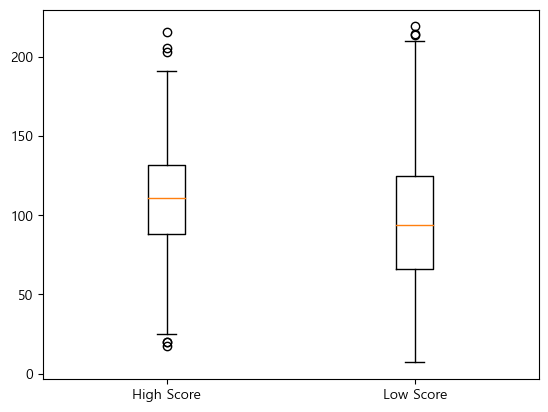

In [310]:
plt.boxplot([high_score['red'], low_score['red']], labels=['High Score', 'Low Score'])
plt.show()

In [311]:
print(np.mean(high_score['red']))
print(np.mean(low_score['red']))
print(np.mean(df['red']))

110.81997871255638
95.96439257584632
101.54489752429524


<Axes: title={'center': 'low score blue'}>

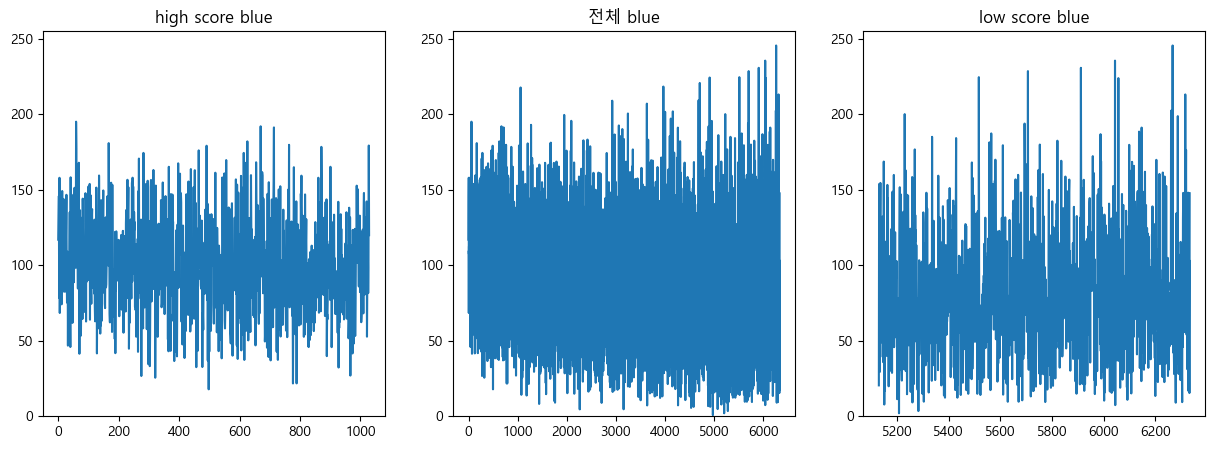

In [312]:
fig = plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.title("high score blue")
plt.ylim(0,255)
high_score['blue'].plot()

plt.subplot(1,3,2)
plt.title("전체 blue")
plt.ylim(0,255)
df['blue'].plot()

plt.subplot(1,3,3)
plt.title("low score blue")
plt.ylim(0,255)
low_score['blue'].plot()

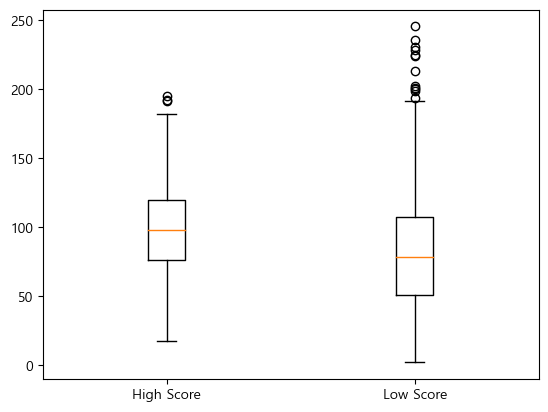

In [313]:
plt.boxplot([high_score['blue'], low_score['blue']], labels=['High Score', 'Low Score'])
plt.show()

In [314]:
print(np.mean(high_score['blue']))
print(np.mean(low_score['blue']))
print(np.mean(df['blue']))

98.98716705912483
81.88614867004812
88.07608429401974


<Axes: title={'center': 'low score green'}>

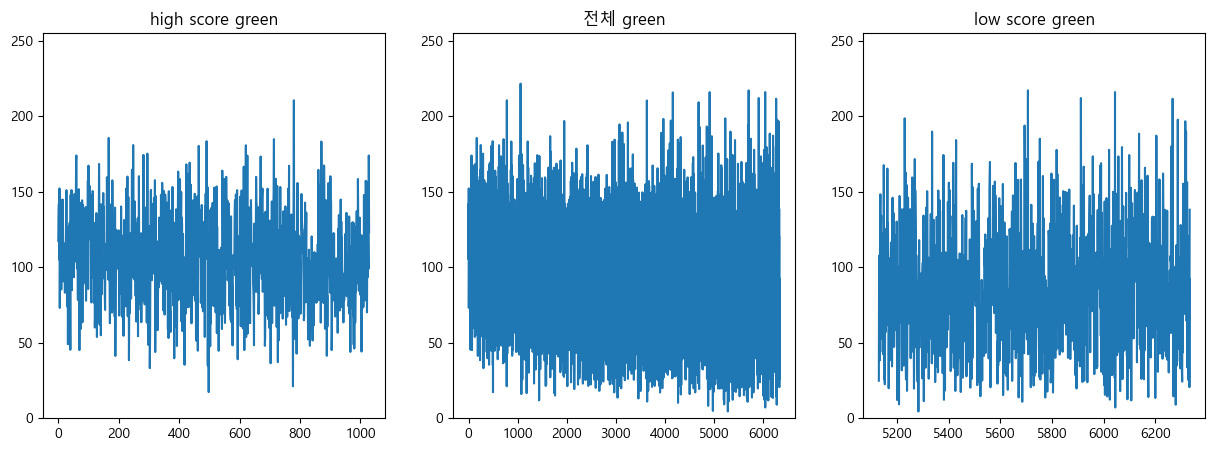

In [315]:
fig = plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.title("high score green")
plt.ylim(0,255)
high_score['green'].plot()

plt.subplot(1,3,2)
plt.title("전체 green")
plt.ylim(0,255)
df['green'].plot()

plt.subplot(1,3,3)
plt.title("low score green")
plt.ylim(0,255)
low_score['green'].plot()

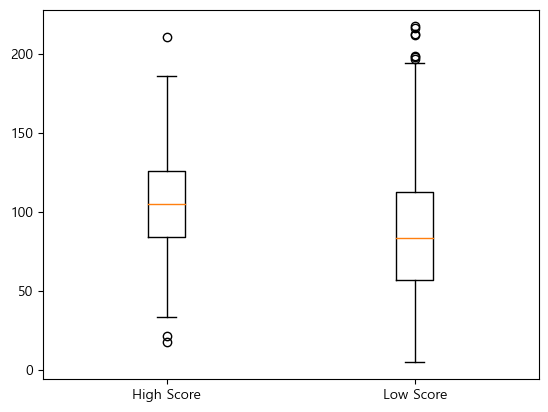

In [316]:
plt.boxplot([high_score['green'], low_score['green']], labels=['High Score', 'Low Score'])
plt.show()

In [317]:
print(np.mean(high_score['green']))
print(np.mean(low_score['green']))
print(np.mean(df['green']))

105.06628021993319
85.7424019390279
92.40970023123923


## 6. Moment

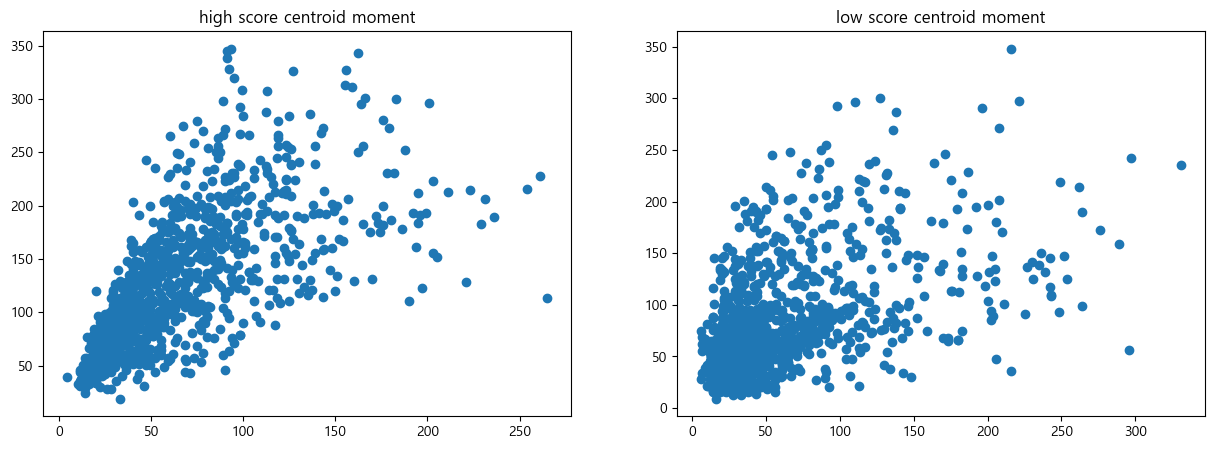

In [318]:
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.scatter(high_score['c_moment_x'], high_score['c_moment_y'])
plt.title('high score centroid moment')

plt.subplot(1,2,2)
plt.scatter(low_score['c_moment_x'], low_score['c_moment_y'])
plt.title('low score centroid moment')
plt.show()

In [319]:
high_score['c_moment']

0        (84, 166)
1        (86, 141)
2       (123, 225)
3        (62, 168)
4        (65, 116)
           ...    
1025     (79, 188)
1026     (96, 171)
1027      (25, 74)
1028     (92, 120)
1029      (46, 57)
Name: c_moment, Length: 1030, dtype: object

In [320]:
low_score['c_moment']

5130     (24, 32)
5131     (20, 24)
5132     (46, 64)
5133     (26, 51)
5134    (14, 116)
          ...    
6329     (27, 50)
6330     (64, 57)
6331     (32, 32)
6332     (26, 36)
6333     (42, 79)
Name: c_moment, Length: 1204, dtype: object

## 7. Contrast

<Axes: title={'center': 'low score contrast'}>

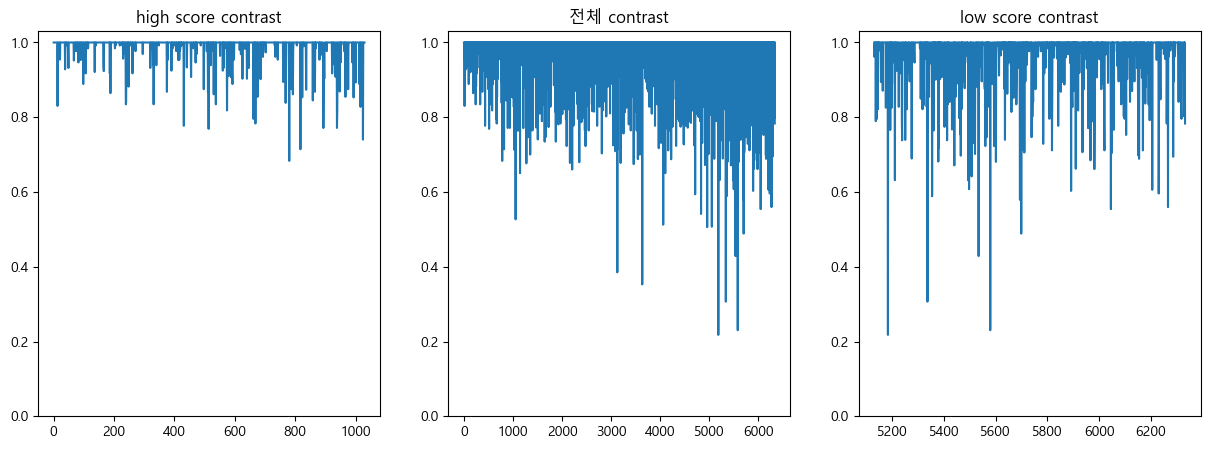

In [321]:
fig = plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.title("high score contrast")
plt.ylim(0,1.03)
high_score['contrast'].plot()

plt.subplot(1,3,2)
plt.title("전체 contrast")
plt.ylim(0,1.03)
df['contrast'].plot()

plt.subplot(1,3,3)
plt.title("low score contrast")
plt.ylim(0,1.03)
low_score['contrast'].plot()

<Axes: title={'center': 'low score brightness sd'}>

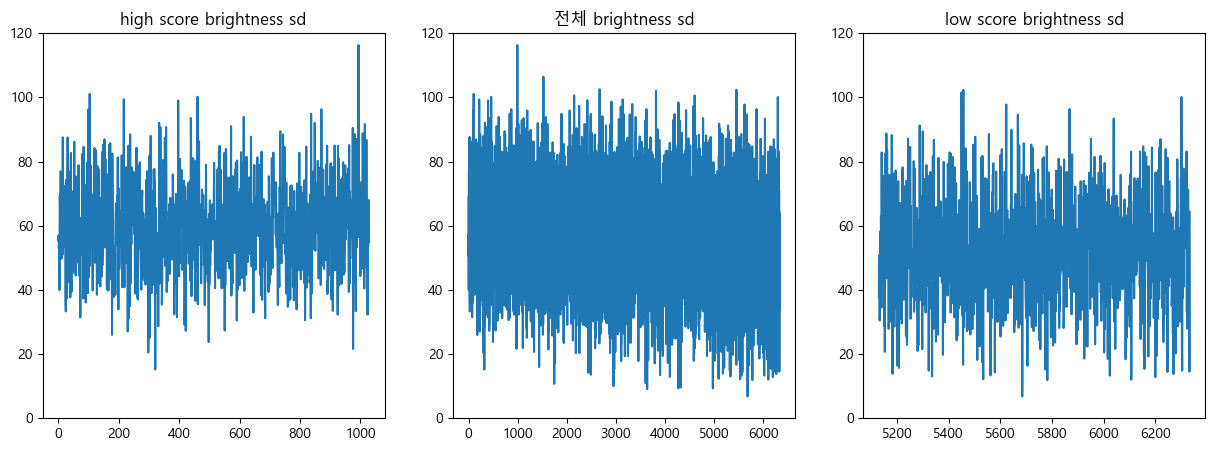

In [358]:
# brightness sd
fig = plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.title("high score brightness sd")
plt.ylim(0,120)
high_score['B_sd'].plot()

plt.subplot(1,3,2)
plt.title("전체 brightness sd")
plt.ylim(0,120)
df['B_sd'].plot()

plt.subplot(1,3,3)
plt.title("low score brightness sd")
plt.ylim(0,120)
low_score['B_sd'].plot()

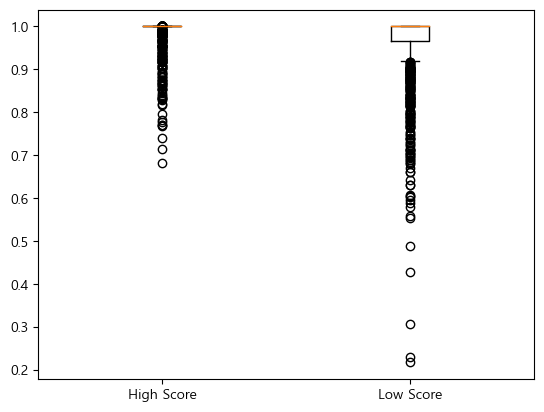

In [322]:
plt.boxplot([high_score['contrast'], low_score['contrast']], labels=['High Score', 'Low Score'])
plt.show()

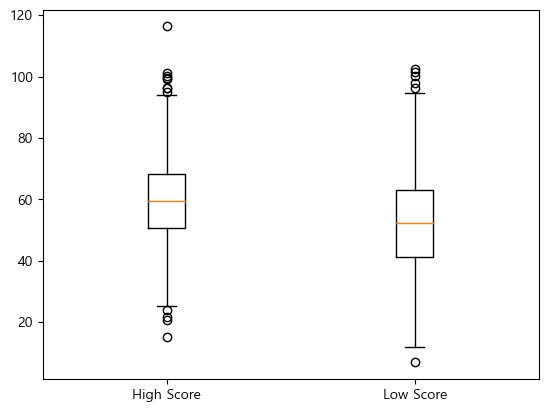

In [359]:
plt.boxplot([high_score['B_sd'], low_score['B_sd']], labels=['High Score', 'Low Score'])
plt.show()

In [323]:
print(np.mean(high_score['contrast']))
print(np.mean(low_score['contrast']))
print(np.mean(df['contrast']))

0.9889017009344762
0.9623137951801182
0.977201815540917


In [360]:
print(np.mean(high_score['B_sd']))
print(np.mean(low_score['B_sd']))
print(np.mean(df['B_sd']))

59.789381426079096
52.22341929702251
56.36381600126373


## 8. bbox prop

<Axes: title={'center': 'low score bbox_size_prop'}>

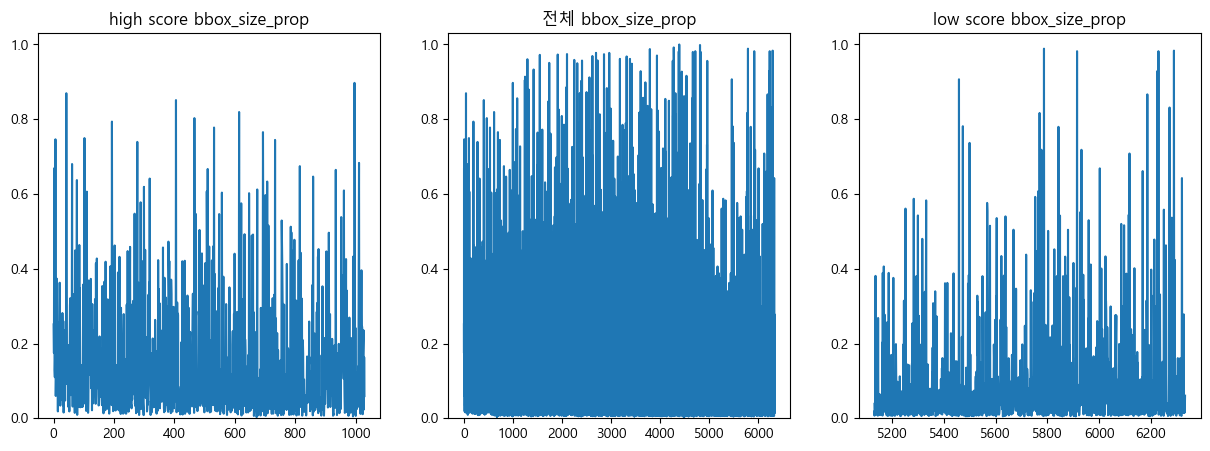

In [324]:
fig = plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.title("high score bbox_size_prop")
plt.ylim(0,1.03)
high_score['bbox_prop'].plot()

plt.subplot(1,3,2)
plt.title("전체 bbox_size_prop")
plt.ylim(0,1.03)
df['bbox_prop'].plot()

plt.subplot(1,3,3)
plt.title("low score bbox_size_prop")
plt.ylim(0,1.03)
low_score['bbox_prop'].plot()

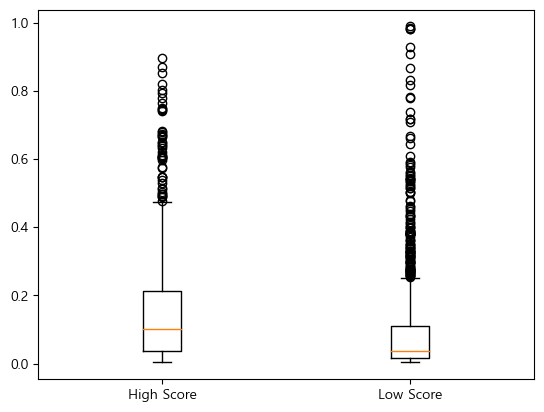

In [325]:
plt.boxplot([high_score['bbox_prop'], low_score['bbox_prop']], labels=['High Score', 'Low Score'])
plt.show()

In [326]:
print(np.mean(high_score['bbox_prop']))
print(np.mean(low_score['bbox_prop']))
print(np.mean(df['bbox_prop']))

0.15211256202581608
0.09575647530214669
0.12574475552063763


## 9. bbox 너비높이 비율

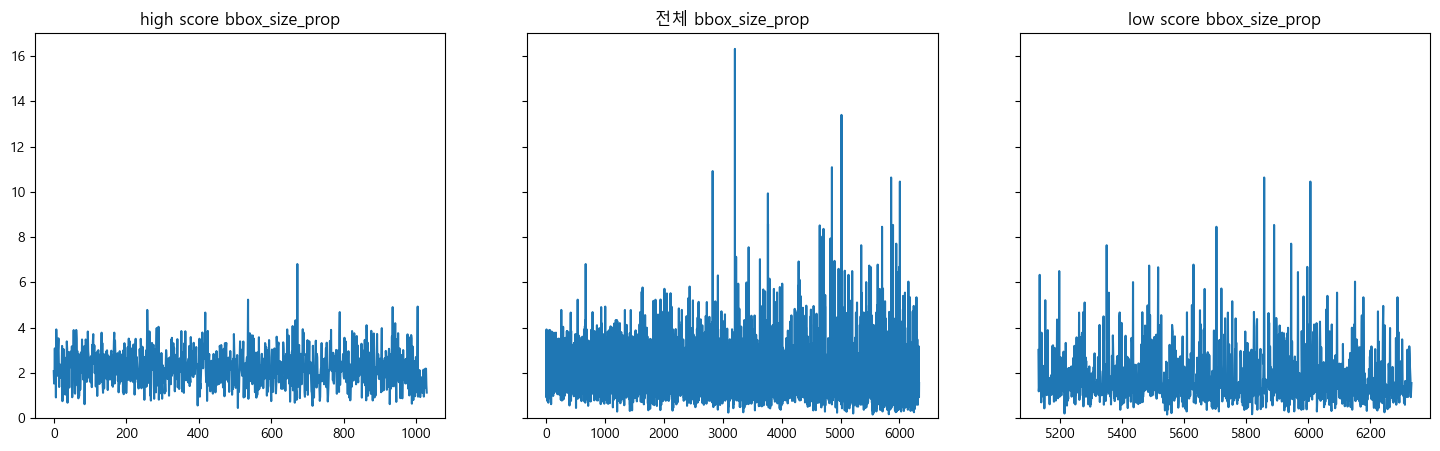

In [327]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# 첫 번째 subplot
axes[0].set_title("high score bbox_size_prop")  
pd.DataFrame(high_score['height'] / high_score['width'].values).plot(ax=axes[0], legend=False)

# 두 번째 subplot
axes[1].set_title("전체 bbox_size_prop")
pd.DataFrame(df['height'] / df['width'].values).plot(ax=axes[1], legend=False)

# 세 번째 subplot
axes[2].set_title("low score bbox_size_prop")
pd.DataFrame(low_score['height'] / low_score['width'].values).plot(ax=axes[2], legend=False)
axes[0].set_ylim(0, 17) 

plt.show()

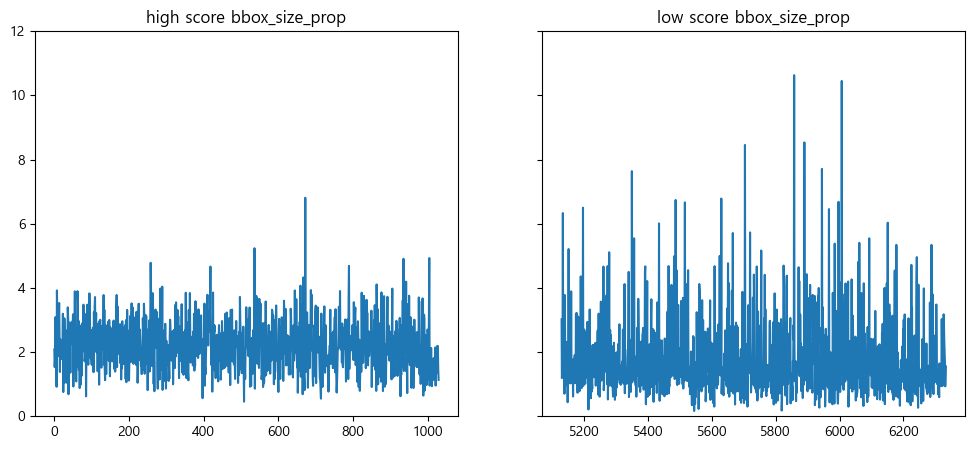

In [346]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# 첫 번째 subplot
axes[0].set_title("high score bbox_size_prop")  
pd.DataFrame(high_score['height'] / high_score['width'].values).plot(ax=axes[0], legend=False)

# 세 번째 subplot
axes[1].set_title("low score bbox_size_prop")
pd.DataFrame(low_score['height'] / low_score['width'].values).plot(ax=axes[1], legend=False)
axes[0].set_ylim(0, 12) 

plt.show()

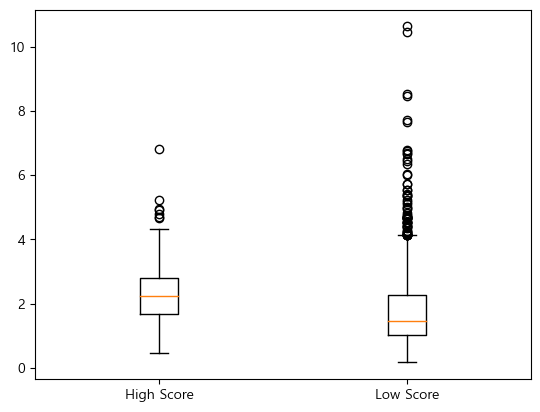

In [328]:
plt.boxplot([high_score['height'] / high_score['width'].values, low_score['height'] / low_score['width'].values], labels=['High Score', 'Low Score'])
plt.show()

In [329]:
print(np.mean(high_score['height'] / high_score['width'].values))
print(np.mean(low_score['height'] / low_score['width'].values))
print(np.mean(df['height'] / df['width'].values))

2.253655078709494
1.8050551487561013
1.9876862707217409


## 10. edge intensity

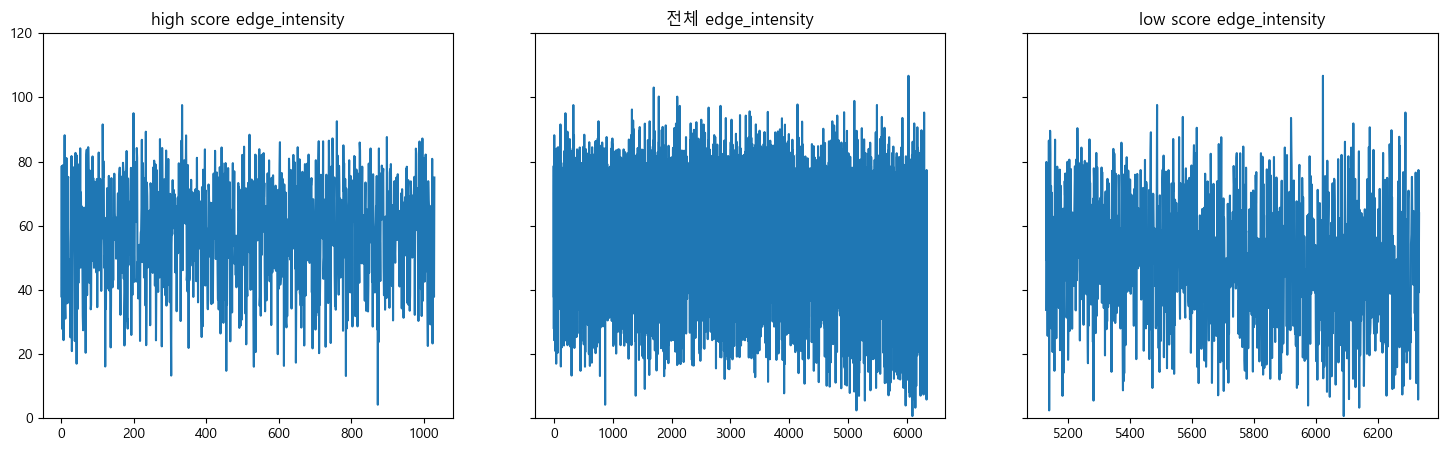

In [350]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# 첫 번째 subplot
axes[0].set_title("high score edge_intensity")  
high_score['edge_intensity'].plot(ax=axes[0], legend=False)

# 두 번째 subplot
axes[1].set_title("전체 edge_intensity")
df['edge_intensity'].plot(ax=axes[1], legend=False)

# 세 번째 subplot
axes[2].set_title("low score edge_intensity")
low_score['edge_intensity'].plot(ax=axes[2], legend=False)
axes[0].set_ylim(0, 120) 

plt.show()

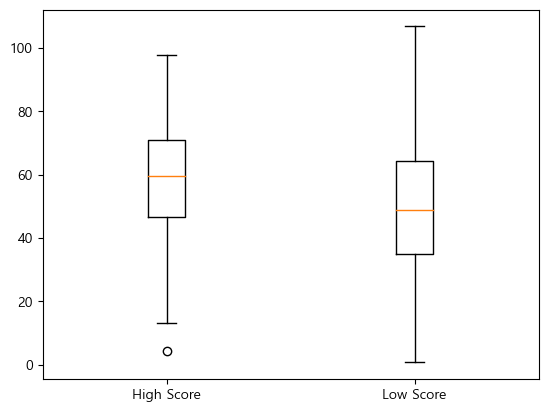

In [337]:
plt.boxplot([high_score['edge_intensity'], low_score['edge_intensity']], labels=['High Score', 'Low Score'])
plt.show()

In [338]:
print(np.mean(high_score['edge_intensity']))
print(np.mean(low_score['edge_intensity']))
print(np.mean(df['edge_intensity']))

57.9389051156665
49.2352653339697
55.582962386273636


## metric 비교, corr 확인

In [352]:
df.columns

Index(['image_file', 'center', 'scale', 'score', 'bbox', 'width', 'height',
       'bbox_size', 'x', 'y', 'entropy', 'laplacian', 'brightness', 'B_sd',
       'red', 'blue', 'green', 'color_var', 'c_moment', 'contrast', 'img_size',
       'edge_intensity', 'c_moment_x', 'c_moment_y', 'bbox_prop'],
      dtype='object')

In [409]:
cols = ['bbox_size','entropy','laplacian','brightness','color_var','contrast','B_sd','edge_intensity','bbox_prop','score']
tmp = pd.DataFrame({'high_score':list(high_score[cols].mean()),
                '전체' :list(df[cols].mean()),
                'low_score' : list(low_score[cols].mean())})
tmp.index = cols
tmp

,high_score,전체,low_score
bbox_size,41367.407188,34228.944171,25638.696945
entropy,7.325675,7.190330,6.982848
laplacian,4151.878905,3399.968211,2267.855847
brightness,106.089093,94.641758,88.354832
color_var,4034.757038,3610.240744,3159.377639
contrast,0.988902,0.977202,0.962314
B_sd,59.789381,56.363816,52.223419
edge_intensity,57.938905,55.582962,49.235265
bbox_prop,0.152113,0.125745,0.095756
score,0.884550,0.713587,0.478401


In [410]:
tmp = df[cols].drop('score',axis=1)
# Min-Max 정규화 수행
df_normalized = (tmp - tmp.min()) / (tmp.max() - tmp.min())

In [411]:
df_normalized['score'] = df['score'].values
df_normalized

,bbox_size,entropy,laplacian,brightness,color_var,contrast,B_sd,edge_intensity,bbox_prop,score
0,0.170120,0.840747,0.073459,0.476461,0.413377,1.000000,0.444060,0.351760,0.248984,0.960156
1,0.124918,0.946316,0.135138,0.602624,0.255447,1.000000,0.458712,0.734605,0.172046,0.946107
2,0.291949,0.884621,0.046253,0.612425,0.250341,1.000000,0.420551,0.256430,0.668015,0.945302
3,0.127300,0.930276,0.227401,0.430184,0.265938,1.000000,0.445766,0.656068,0.126490,0.942805
4,0.078072,0.893484,0.112816,0.682448,0.136853,1.000000,0.302549,0.737028,0.107156,0.941582
...,...,...,...,...,...,...,...,...,...,...
6329,0.009809,0.708786,0.020155,0.256285,0.072763,0.747940,0.244782,0.444830,0.011934,0.213297
6330,0.026876,0.482980,0.001026,0.137483,0.306506,1.000000,0.519210,0.048502,0.034498,0.212928
6331,0.009659,0.898845,0.100830,0.425764,0.150545,0.974687,0.339536,0.723073,0.011814,0.201631
6332,0.007585,0.594222,0.015093,0.077443,0.012762,1.000000,0.070513,0.363438,0.017056,0.000000


In [412]:
normalized_high_score = df_normalized[df_normalized['score']>0.85]
normalized_low_score = df_normalized[df_normalized['score']<0.6]

In [413]:
tmp = pd.DataFrame({'high_score':normalized_high_score.mean(),
                '전체' :df_normalized.mean(),
                'low_score' : normalized_low_score.mean()})
tmp

,high_score,전체,low_score
bbox_size,0.108520,0.089363,0.066311
entropy,0.895086,0.873058,0.839289
laplacian,0.127432,0.104311,0.069500
brightness,0.463037,0.410543,0.381713
color_var,0.295855,0.264220,0.230622
contrast,0.985813,0.970857,0.951826
B_sd,0.483804,0.452517,0.414701
edge_intensity,0.539769,0.517557,0.457711
bbox_prop,0.149540,0.123092,0.093013
score,0.884550,0.713587,0.478401


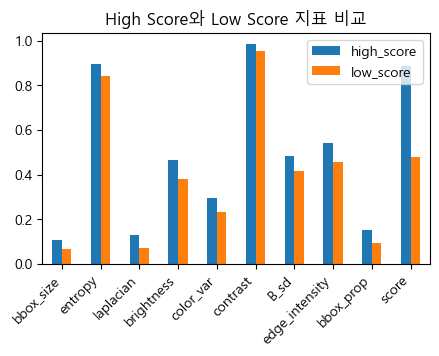

In [414]:
# 'high_score'와 'low_score' 비교를 위한 바 차트
tmp[['high_score', 'low_score']].plot(kind='bar', figsize=(5, 3))
plt.title('High Score와 Low Score 지표 비교')
plt.xticks(rotation=45, ha='right')
plt.show()

In [396]:
df_normalized.corr()['score']

bbox_size         0.106493
entropy           0.204105
laplacian         0.190469
brightness        0.139761
color_var         0.149576
contrast          0.140210
B_sd              0.153803
edge_intensity    0.176173
c_moment_x        0.044288
c_moment_y        0.229052
bbox_prop         0.104145
score             1.000000
Name: score, dtype: float64

### @ bbox size 분포 확인

<Axes: title={'center': 'low score bbox_size'}>

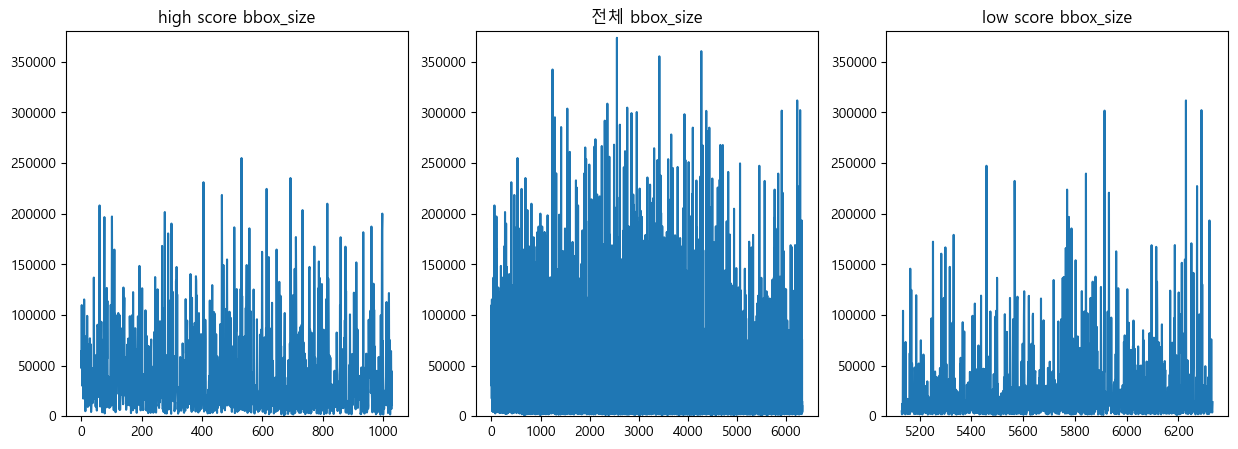

In [408]:
fig = plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.title("high score bbox_size")
plt.ylim(0,380000)
high_score['bbox_size'].plot()

plt.subplot(1,3,2)
plt.title("전체 bbox_size")
plt.ylim(0,380000)
df['bbox_size'].plot()

plt.subplot(1,3,3)
plt.title("low score bbox_size")
plt.ylim(0,380000)
low_score['bbox_size'].plot()

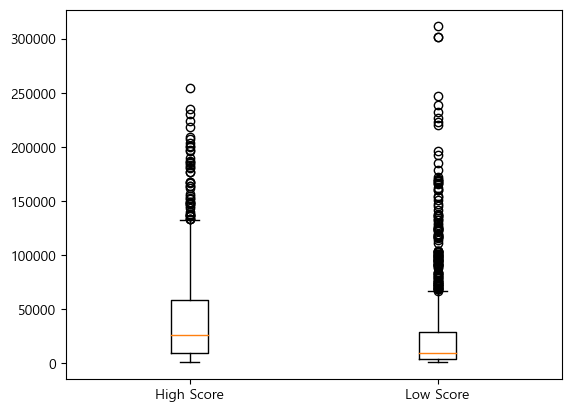

In [401]:
plt.boxplot([high_score['bbox_size'], low_score['bbox_size']], labels=['High Score', 'Low Score'])
plt.show()

print(np.mean(high_score['edge_intensity']))
print(np.mean(low_score['edge_intensity']))
print(np.mean(df['edge_intensity']))